Processing...
Done!
e:\Work\_AMine\AI\Uni.HW.GNN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Work\_AMine\AI\Uni.HW.GNN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0, Loss: 67.9926, Accuracy: 0.0640
Epoch 10, Loss: 18.6199, Accuracy: 0.3190


e:\Work\_AMine\AI\Uni.HW.GNN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Work\_AMine\AI\Uni.HW.GNN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20, Loss: 5.5938, Accuracy: 0.1570
Epoch 30, Loss: 2.6798, Accuracy: 0.0660


e:\Work\_AMine\AI\Uni.HW.GNN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Work\_AMine\AI\Uni.HW.GNN\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 40, Loss: 1.5272, Accuracy: 0.3650
Epoch 50, Loss: 1.0382, Accuracy: 0.5110
Epoch 60, Loss: 0.9070, Accuracy: 0.5870
Epoch 70, Loss: 0.8348, Accuracy: 0.6920
Epoch 80, Loss: 0.7682, Accuracy: 0.7040
Epoch 90, Loss: 0.7116, Accuracy: 0.7040


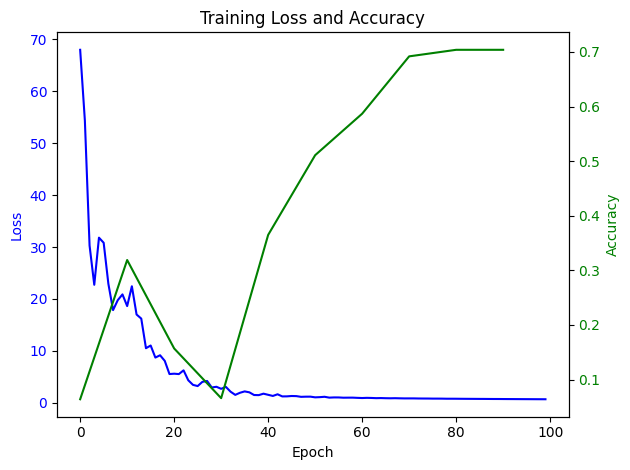

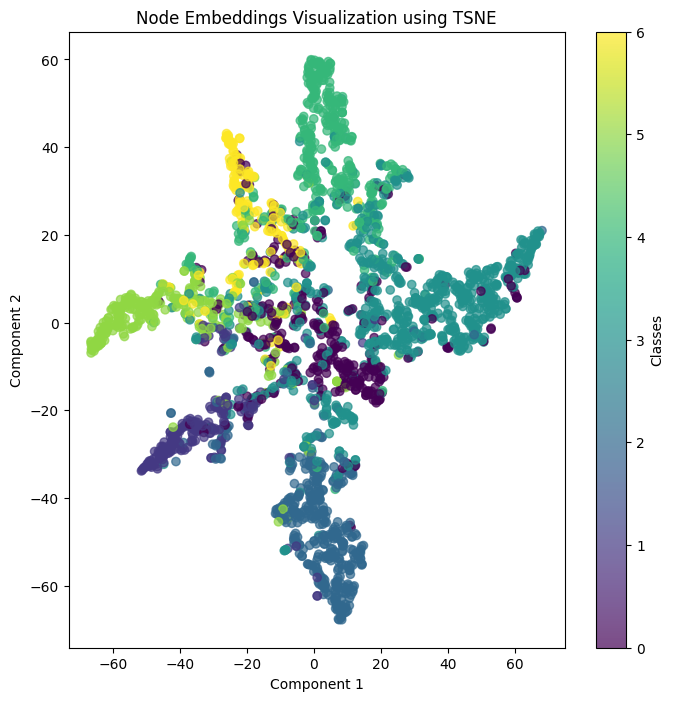

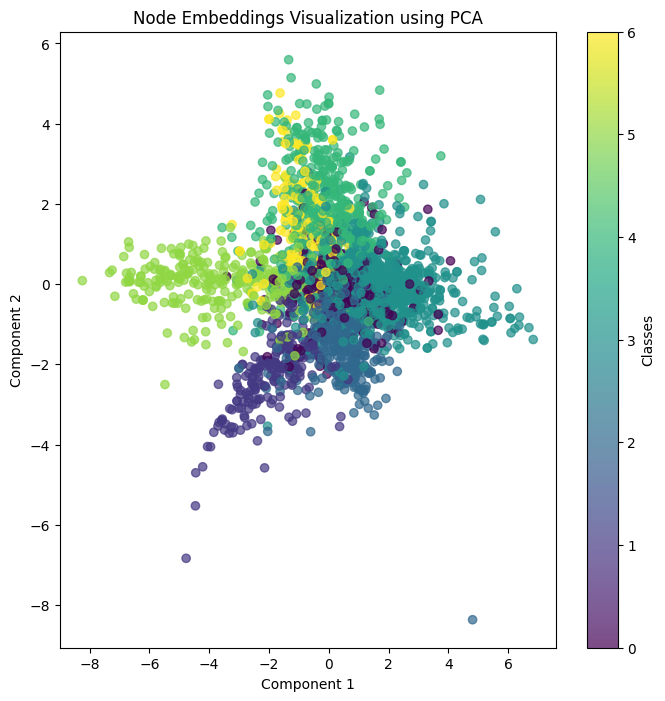

Final Metrics - Accuracy: 0.7110, Precision: 0.7711, Recall: 0.7110, F1-Score: 0.7198


In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Loading dataset
dataset = Planetoid(root='../data', name='Cora')
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Generate synthetic features
num_nodes = data.num_nodes
publication_year = np.random.randint(2000, 2021, size=(num_nodes, 1))
impact_factor = np.random.uniform(0.1, 10.0, size=(num_nodes, 1))

# Concatenate synthetic features with existing node features
additional_features = torch.tensor(np.hstack([publication_year, impact_factor]), dtype=torch.float)
data.x = torch.cat([data.x, additional_features.to(device)], dim=1)

# Updated input dimension with additional features
input_dim = dataset.num_node_features + additional_features.shape[1]

# Defining the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training and testing functions
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = accuracy_score(data.y[test_mask].cpu(), pred.cpu())
        prec = precision_score(data.y[test_mask].cpu(), pred.cpu(), average='weighted')
        rec = recall_score(data.y[test_mask].cpu(), pred.cpu(), average='weighted')
        f1 = f1_score(data.y[test_mask].cpu(), pred.cpu(), average='weighted')
    return acc, prec, rec, f1

# Function to visualize node embeddings using t-SNE or PCA
def visualize_embeddings(embeddings, labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_embeddings = reducer.fit_transform(embeddings)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Classes")
    plt.title(f'Node Embeddings Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Hyperparameters
hidden_dim = 16
learning_rate = 0.01
epochs = 100

# Initialize model and optimizer
model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

# Training loop
losses = []
accuracies = []
for epoch in range(epochs):
    loss = train(model, data, optimizer)
    losses.append(loss)

    if epoch % 10 == 0:
        acc, prec, rec, f1 = test(model, data)
        accuracies.append(acc)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Plot training loss and accuracy over epochs
fig, ax1 = plt.subplots()
ax1.plot(losses, label='Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(range(0, epochs, 10), accuracies, label='Accuracy', color='green')
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Training Loss and Accuracy")
fig.tight_layout()
plt.show()

# Get the final embeddings from the model for visualization
model.eval()
with torch.no_grad():
    final_embeddings = model(data).cpu().numpy()

# Visualize embeddings using t-SNE or PCA
visualize_embeddings(final_embeddings, data.y.cpu(), method='tsne')
visualize_embeddings(final_embeddings, data.y.cpu(), method='pca')

# Final evaluation metrics
acc, prec, rec, f1 = test(model, data)
print(f"Final Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")